# MODEL VISUALIZATION USING TENSORBOARD

### Importing all the required libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

### Data Pre-processing 
- Defining the transformer to tranform the input size of the image ,convert it into a tensor format and Normalize the array

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

- Downloading the test and train dataset and loading those dataset using dataloader

In [3]:
batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


### Helper Functions
- This method displays a PyTorch tensor as an image using Matplotlib, optionally converting it to grayscale.

In [4]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5    
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

### Define the Neural Network Setup for the dataset 

In [5]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

### Define a loss function and a optimizer for the model

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### Use the SummaryWriter to write on the tensorboard
- Create an object of the SummaryWriter and 'runs/cifar10' specifies the directory where the SummaryWriter will save the log files for TensorBoard, which will store metrics, images, and other data related to the CIFAR-10 experiment.

In [7]:
writer = SummaryWriter('runs/cifar10')

### Write an image onto the  TensorBoard, in form of a grid - using make_grid.

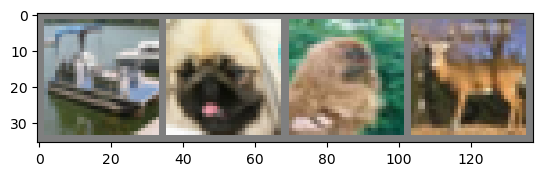

In [8]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=False)
writer.add_image('CIFAR10_Images', img_grid)

### Launching the TensorBoard

In [9]:
! tensorboard --logdir=runs

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.16.2 at http://localhost:6006/ (Press CTRL+C to quit)
^C


### Inspect the model : visualize the model  built.

In [12]:
writer.add_graph(net, images)

In [13]:
! tensorboard --logdir=runs

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.16.2 at http://localhost:6006/ (Press CTRL+C to quit)
W0619 22:38:52.436221 6125563904 plugin_event_accumulator.py:369] Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
^C


### Helper Functions
- Produces predictions and their associated probabilities using the trained network and a list of images.
- Creates a Matplotlib Figure using a trained network, along with images and labels from a batch. This figure displays the network's top prediction and its probability, alongside the actual label, with the information color-coded to indicate whether the prediction was correct. Utilizes the "images_to_probs" function.

In [14]:
def images_to_probs(net, images):
    output = net(images)
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels):
    preds, probs = images_to_probs(net, images)
    fig = plt.figure(figsize=(10,25))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=False)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

### Train the neural network for one epoch, logging the training loss and a figure comparing predictions to actual labels every 1000 batches.

In [15]:
running_loss = 0.0
for epoch in range(1):

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 1000 == 999:   
            writer.add_scalar('training loss',
                            running_loss / 1000,
                            epoch * len(trainloader) + i)
            writer.add_figure('predictions vs. actuals',
                            plot_classes_preds(net, inputs, labels),
                            global_step=epoch * len(trainloader) + i)
            running_loss = 0.0
print('Finished Training')

Finished Training


In [16]:
! tensorboard --logdir=runs

W0619 22:43:00.046293 6159364096 plugin_event_accumulator.py:369] Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.16.2 at http://localhost:6006/ (Press CTRL+C to quit)
^C


### Creating the PR (Precision Recall) Curves for every category that is to be predicted using the helper function 'add_pr_curve_tensorboard'.

In [17]:
class_probs = []
class_label = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        output = net(images)
        class_probs_batch = [F.softmax(el, dim=0) for el in output]

        class_probs.append(class_probs_batch)
        class_label.append(labels)

test_probs = torch.cat([torch.stack(batch) for batch in class_probs])
test_label = torch.cat(class_label)

# helper function
def add_pr_curve_tensorboard(class_index, test_probs, test_label, global_step=0):
    tensorboard_truth = test_label == class_index
    tensorboard_probs = test_probs[:, class_index]

    writer.add_pr_curve(classes[class_index],
                        tensorboard_truth,
                        tensorboard_probs,
                        global_step=global_step)
    writer.close()

for i in range(len(classes)):
    add_pr_curve_tensorboard(i, test_probs, test_label)

In [ ]:
! tensorboard --logdir=runs

W0619 22:47:41.015388 6159495168 plugin_event_accumulator.py:369] Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.16.2 at http://localhost:6006/ (Press CTRL+C to quit)
